#### BaoStock

- http://baostock.com

In [128]:
import baostock as bs
import pandas as pd
import datetime
import sqlite3
import numpy as np


#import matplotlib.pyplot as plt
#%matplotlib inline

from pyecharts.charts import Bar
from pyecharts.charts import Line
import pyecharts.options as opts

In [2]:
indices={
    'sh.000001':'上证指数',
    'sz.399001':'深证成指',
    'sz.399106':'深证综指',
    'sh.000300':'沪深300',
    'sz.399006':'创业板',
    'sh.000016':'上证50'
}
# indices.keys()
# indices.values()


# 市场指数字段
market_columns=[
     'date',# 日期
     'code',# 代码
     'open',# 开盘
     'high',# 最高
     'low',# 最低
     'close',# 收
     'preclose',# 昨收
     'volume',# 成交数量（股）
     'amount',# 成交金额（元）
     'pctChg',# 涨跌幅
     'turn',# 换手率
    ]


# baostock fileds
b_fields = ["date","code","open","high","low","close","preclose","volume","amount","adjustflag","turn","tradestatus","pctChg","peTTM","pbMRQ","psTTM","pcfNcfTTM","isST"]


def select(sql):
    if str(sql).lower().find('select') < 0:
        raise ValueError('Select Statement only!!! For args sql = ', sql)

    # 获取数据库连接，数据库文件不存在时，会自动创建数据库文件
    conn = sqlite3.connect('stock.db')
    # 获取游标
    cursor = conn.cursor()
    cursor.execute(sql)
    res = cursor.fetchall()
    cursor.close()
    conn.close()
    return res



def executeUpdate(sql):
    # 获取数据库连接，数据库文件不存在时，会自动创建数据库文件
    conn = sqlite3.connect('stock.db')
    # 获取游标
    cursor = conn.cursor()
    cursor.execute(sql)
    cursor.close()
    conn.commit()
    conn.close()

### 1、市场指数分析 

In [ ]:
bs.login()
"""
获取历史K线
    @param code 证券代码
    @param start_date
    @param end_date
    @param fields 返回指标，半角逗号分隔，支持的指标如下：
                            date    交易所行情日期
                            code    证券代码
                            open    开盘价
                            high    最高价
                            low    最低价
                            close    收盘价
                            preclose    前收盘价
                            volume    成交量（累计 单位：股）
                            amount    成交额（单位：人民币元）
                            adjustflag    复权状态(1：后复权， 2：前复权，3：不复权）
                            turn    换手率
                            tradestatus    交易状态(1：正常交易 0：停牌）
                            pctChg    涨跌幅（百分比）
                            peTTM    滚动市盈率
                            pbMRQ    市净率
                            psTTM    滚动市销率
                            pcfNcfTTM    滚动市现率
                            isST    是否ST股，1是，0否
    @param frequency：数据类型，默认为d，日k线；d=日k线、w=周、m=月、5=5分钟、15=15分钟、30=30分钟、60=60分钟k线数据，不区分大小写；指数没有分钟线数据；周线每周最后一个交易日才可以获取，月线每月最后一个交易日才可以获取。
    @param adjustflag：复权类型，默认不复权：3；1：后复权；2：前复权。已支持分钟线、日线、周线、月线前后复权。 BaoStock提供的是涨跌幅复权算法复权因子
"""
rs = bs.query_history_k_data_plus('sz.000001', ','.join(iter(b_fields)), start_date='2021-01-04', end_date='2021-01-04', frequency='d', adjustflag='3')
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())

df = pd.DataFrame(data_list, columns=b_fields)
bs.logout()
df

In [ ]:
rs = bs.query_history_k_data_plus('sh.600276', ','.join(iter(b_fields)), start_date='2020-12-02', end_date='2021-02-02', frequency='d', adjustflag='3')
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())

df = pd.DataFrame(data_list, columns=b_fields)
df

In [ ]:
bs.logout()

In [61]:
#
#
# 获取指定日期范围内的指数记录，并插入数据库
# code 指数代码
# start_date 开始日期
# end_date 结束日期
#
#
def dump_zs001(code, start_date, end_date):
    # 指数数据list
    zs_data=[]
    res = bs.query_history_k_data_plus(code, "date,code,open,high,low,close,preclose,volume,amount,pctChg,turn",
        start_date, end_date, frequency="d")
    # 提取数据到data_list
    if res.error_code == '0':
        while res.next():
            zs_data.append(res.get_row_data())
    else:
        return False
            

    print(start_date, code, '获取记录数：',len(zs_data))
    # print(zs_data)
    # 创建指数记录表
    '''cursor.execute(
        "create table market_index(
            date comment '日期',
            code comment '指数代码',
            open comment '开盘',
            high comment '最高',
            low comment '最低',
            close comment '收盘',
            preclose comment '昨收',
            volume comment '成交数量',
            amount comment '成交金额',
            pctChg comment '涨跌幅',
            turn comment '换手率')")
    '''

    if len(zs_data)>0:

        # 获取数据库连接，数据库文件不存在时，会自动创建数据库文件
        conn = sqlite3.connect('stock.db')

        # 获取游标
        cursor = conn.cursor()
        # 插入数据库
        cres=cursor.executemany('insert into market_index(date,code,open,high,low,close,preclose,volume,amount,pctChg,turn) values(?,?,?,?,?,?,?,?,?,?,?)',
             zs_data)
        # print('cres', cres)
        # 输出提交记录数，并提交
        print(start_date, code, '插入记录数：', cursor.rowcount)
        # 先关闭游标
        # cursor.colse() # 为什么报错：cursor对象没有close()属性？？？
        # 再提交
        conn.commit()
        conn.close()
        print("√√√√√√记录dump完成√√√√√√")
        return True
    else:
        return False


# 从结果中获取成交量
cjl = lambda x,y: y[y.code == x].amount.values[0]
# 从结果中获取换手率
hsl = lambda x,y: y[y.code == x].turn.values[0]

#
# 收盘文字播报
#
def closeReport(bizD):
    # 前一交易日
    #preBizDay = (datetime.datetime.strptime(bizD, '%Y-%m-%d') + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')
    # 前一交易日，从数据库里面取
    q_bizdays = select("SELECT DISTINCT date FROM market_index WHERE code='sh.000001' AND date<='%s' ORDER BY date desc limit 2" % bizD)
    preBizDay = q_bizdays[1][0]
    qres0001 = select("SELECT * FROM market_index WHERE date BETWEEN '%s' AND '%s'" % (preBizDay, bizD))
    # 查询结果转为pandas DataFrame
    qmi = pd.DataFrame(data=qres0001, columns=market_columns)
    # 指数文字描述
    # 业务日的数据
    bizDayData = qmi[qmi.date == bizD]
    # 业务日期前一天的数据
    preBizDayData = qmi[qmi.date == preBizDay]
    # 从结果中获取涨幅
    zszf = lambda x,y: y[y.code == x].pctChg.values[0]
    amountSH000001 = cjl('sh.000001', bizDayData)
    amountSZ399106 = cjl('sz.399106', bizDayData)
    # 成交总量
    tamount = amountSH000001 + amountSZ399106

    # 前一日成交总量
    ptamount = 0
    if len(preBizDayData.values):
        ptamount = cjl('sh.000001', preBizDayData) + cjl('sz.399106', preBizDayData)

    # 日环比
    dayRate = lambda x, y : (x - y) * 100 / y
    # 成交量描述
    print('``%s··证券市场总成交量：%.2f亿元 ++++++ %s' % (bizD, tamount / 1e8,
            '' if ptamount == 0 else '上一交易日``%s``成交量：%.2f亿元，环比涨幅：%.2f%%' % (preBizDay, ptamount / 1e8, dayRate(tamount, ptamount)) ))

    for idx,name in indices.items():
        print('````````````%s··涨幅：%.2f%%，成交量：%.2f亿元，换手率：%.2f%%' % (name, zszf(idx, bizDayData), cjl(idx, bizDayData)/ 1e8, hsl(idx, bizDayData)))

In [ ]:
# 市场指数表，增加“换手率”字段
# executeUpdate("ALTER TABLE market_index ADD turn COMMENT '换手率'")

# 补充“换手率”字段
# code 指数代码
# start_date 开始日期
# end_date 结束日期
def dump_zsturn001(code, start_date, end_date):
    # 指数数据list
    zs_data=[]
    res = bs.query_history_k_data_plus(code, "turn,date,code", start_date, end_date, frequency="d")
    # 提取数据到data_list
    if res.error_code == '0':
        while res.next():
            zs_data.append(res.get_row_data())

    print(start_date, code, '获取记录数：',len(zs_data))

    if len(zs_data)>0:

        # 获取数据库连接，数据库文件不存在时，会自动创建数据库文件
        conn = sqlite3.connect('stock.db')

        # 获取游标
        cursor = conn.cursor()
        # 插入数据库
        cres=cursor.executemany('update market_index set turn=? where date=? and code=?', zs_data)
        # 输出提交记录数，并提交
        print(start_date, code, '插入记录数：', cursor.rowcount)
        # 先关闭游标
        # cursor.colse() # 为什么报错：cursor对象没有close()属性？？？
        # 再提交
        conn.commit()
        conn.close()

    print("√√√√√√补充‘换手率’完成√√√√√√")

In [ ]:
# executeUpdate('DELETE FROM market_index')

In [ ]:
select("select * from market_index where date='2021-01-27'")

In [ ]:
select("SELECT count(*) FROM market_index where date like '2021%' and code='sh.000001'")

In [ ]:
select("SELECT date FROM market_index where date like '2021%' and code='sh.000001'")

In [ ]:
# 测试--dump市场指数数据
# dump_zs001('sh.000001', '2000-01-01', '2000-12-31')
# 测试--补充换手率
# dump_zsturn001('sh.000001', '2021-01-01', '2021-12-31')

In [ ]:
# lg = bs.login()
# print(lg.error_code)
# print(lg.error_msg)

# 逐个指数获取市场指数记录，并插入数据库
# 2000-01-01~2021-01-27
#for idx in indices.keys():
#    for yr in range(0, 22):
#        dump_zs001(idx, '20%02d-01-01' % yr, '20%02d-12-31' % yr)

# 逐个指数获取市场指数记录，补充“换手率”
# 2000-01-01~2021-01-27
# for idx in indices.keys():
#    for yr in range(0, 22):
#        dump_zsturn001(idx, '20%02d-01-01' % yr, '20%02d-12-31' % yr)

In [ ]:
#executeUpdate(
'''
CREATE TABLE stock_hs300_zz500 (
    date text comment '记录日期',
    updateDate text comment '更新日期',
    code text comment '代码',
    code_name text comment '名称',
    stock_type text comment 'hs300 or zz500',
    is_sh50 boolean comment '是上证50:1')
'''
#)

# 保存沪深300和中证500的成分股，并标记上证50成分股
def dump_hs800(s_date):
    bs.login()
    sh50 = bs.query_sz50_stocks()
    hs300 = bs.query_hs300_stocks()
    zz500 = bs.query_zz500_stocks()
    print(hs300.error_code)
    print(hs300.error_msg)
    bs.logout()

    list50 = []
    while sh50.next():
        list50.append(sh50.get_row_data()[1])

    stocks = []
    while hs300.next():
        stocks.append([s_date, *hs300.get_row_data(), 'hs300', 1 if hs300.get_row_data()[1] in list50 else 0])
    while zz500.next():
        stocks.append([s_date, *zz500.get_row_data(), 'zz500', 0])

    if len(stocks)>0:
        # 获取数据库连接，数据库文件不存在时，会自动创建数据库文件
        conn = sqlite3.connect('stock.db')

        # 获取游标
        cursor = conn.cursor()
        # 插入数据库
        cres=cursor.executemany('insert into stock_hs300_zz500(date,updateDate,code,code_name,stock_type,is_sh50) values(?,?,?,?,?,?)', stocks)
        # 输出提交记录数，并提交
        #print('插入记录数：', cursor.rowcount)
        # 先关闭游标
        # cursor.colse() # 为什么报错：cursor对象没有close()属性？？？
        # 再提交
        conn.commit()
        conn.close()

In [59]:
bizDate = datetime.datetime.now().strftime("%Y-%m-%d")
fres = True
# 数据库的最大日期
q_max_date = select("SELECT MAX(date) FROM market_index WHERE code='sh.000001'")

# dump当日市场指数数据
if q_max_date[0][0] < bizDate:
    lg = bs.login()
    try:
        for idx in indices.keys():
            """
            `and`运算有短路效果
            如果有一次函数调用的结果是Fasle导致`fres`为False后，就不会再执行循环中后续的函数调用
            """
            fres = fres and dump_zs001(idx, bizDate, bizDate)
            print('----', fres)
    except BaseException as e:
        fres = False
        print('××××保存当日市场数据异常×××××', e)
    finally:
        bs.logout()

# 如果今天数据保存成功，进行收盘分析
if fres:
    closeReport(bizDate)

login success!
2021-02-05 sh.000001 获取记录数： 1
2021-02-05 sh.000001 插入记录数： 1
√√√√√√记录dump完成√√√√√√
---- True
2021-02-05 sz.399001 获取记录数： 1
2021-02-05 sz.399001 插入记录数： 1
√√√√√√记录dump完成√√√√√√
---- True
2021-02-05 sz.399106 获取记录数： 1
2021-02-05 sz.399106 插入记录数： 1
√√√√√√记录dump完成√√√√√√
---- True
2021-02-05 sh.000300 获取记录数： 1
2021-02-05 sh.000300 插入记录数： 1
√√√√√√记录dump完成√√√√√√
---- True
2021-02-05 sz.399006 获取记录数： 1
2021-02-05 sz.399006 插入记录数： 1
√√√√√√记录dump完成√√√√√√
---- True
2021-02-05 sh.000016 获取记录数： 1
2021-02-05 sh.000016 插入记录数： 1
√√√√√√记录dump完成√√√√√√
---- True
logout success!
``2021-02-05··证券市场总成交量：8911.08亿元 ++++++ 上一交易日``2021-02-04``成交量：9424.97亿元，环比涨幅：-5.45%
````````````上证指数··涨幅：-0.16%，成交量：3973.92亿元，换手率：0.79%
````````````深证成指··涨幅：-0.65%，成交量：4937.16亿元，换手率：1.66%
````````````深证综指··涨幅：-0.88%，成交量：4937.16亿元，换手率：1.70%
````````````沪深300··涨幅：0.17%，成交量：3954.00亿元，换手率：0.69%
````````````创业板··涨幅：-0.21%，成交量：1620.02亿元，换手率：2.03%
````````````上证50··涨幅：1.03%，成交量：1062.77亿元，换手率：0.33%


In [ ]:
q_bizdays = select("SELECT DISTINCT date FROM market_index WHERE code='sh.000001' AND date<='2021-02-01' ORDER BY date desc limit 2")
q_bizdays[1][0]

In [ ]:
# 读取近100个交易日的成交量
amount100 = select("SELECT date,code,amount FROM market_index WHERE code IN ('sh.000001','sz.399106') ORDER BY date DESC LIMIT 200")
shamout = {}
szamout = {}
for amt in amount100:
    if amt[1] == 'sh.000001':
        shamout[amt[0]] = amt[2]
    if amt[1] == 'sz.399106':
        szamout[amt[0]] = amt[2]

#合计两市成交量
tamt = {}
for i in shamout.keys():
    tamt[i] = round((shamout[i] + szamout[i]) / 1e8, 2)
# 按照日期排序，排序结果是一个tuple的list，将其转换为dict
sortedamt = dict(sorted(tamt.items(), key=lambda x: x[0]))

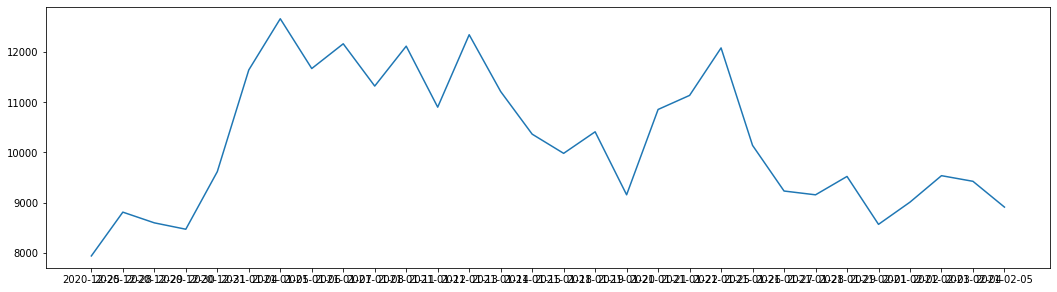

In [127]:
plt.figure(figsize=(18,4.8))
plt.plot([*sortedamt.keys()][-30:], [*sortedamt.values()][-30:])

In [147]:
from pyecharts.charts import Line
import pyecharts.options as opts
line = Line()

line.add_xaxis([*sortedamt.keys()][-60:])
line.add_yaxis("成交量", [*sortedamt.values()][-60:], is_smooth=True,
               markpoint_opts=opts.MarkPointOpts(
                   data = [
                       opts.MarkPointItem(type_="max", name="最大值"),
                       opts.MarkPointItem(type_="min", name="最小值")
                   ]),
               markline_opts=opts.MarkLineOpts(
                   data = [opts.MarkLineItem(type_="average", name="平均值")]),
               is_symbol_show=False
              )
line.set_global_opts(
    title_opts=opts.TitleOpts(title='近期成交量'),
    tooltip_opts=opts.TooltipOpts(trigger="axis")
)
line.render_notebook()

In [130]:
bar = Bar()

bar.add_xaxis([*sortedamt.keys()][-30:])
bar.add_yaxis("日期", [*sortedamt.values()][-30:])
bar.render_notebook()

### 2、个股分析

In [ ]:
bs.login()
# A股证券基本资料
# query_stock_basic(code='', code_name='')
#    A股证券基本资料
#    @param code: 证券代码，可为空
#    @param code_name: 证券名称，可为空，支持模糊查询
rs = bs.query_stock_basic(code_name='茅台')
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())

print(rs.fields)
print(data_list)
bs.logout()

In [ ]:
#executeUpdate(
"""
CREATE table stock_k_data_d (
	date comment "交易所行情日期",
	code comment "证券代码",
	open comment "开盘价",
	high comment "最高价",
	low comment "最低价",
	close comment "收盘价",
	preclose comment "前收盘价",
	volume comment "成交量（累计 单位：股）",
	amount comment "成交额（单位：人民币元）",
	adjustflag comment "复权状态(1：后复权， 2：前复权，3：不复权）",
	turn comment "换手率",
	tradestatus comment "交易状态(1：正常交易 0：停牌）",
	pctChg comment "涨跌幅（百分比）",
	peTTM comment "滚动市盈率",
	pbMRQ comment "市净率",
	psTTM comment "滚动市销率",
	pcfNcfTTM comment "滚动市现率",
	isST comment "是否ST股，1是，0否"
)
"""
#)

In [3]:
# 保存个股每日K线数据
def dump_gg001(code, start_date, end_date):
    # 指数数据list
    zs_data=[]
    str_fields = ','.join(iter(b_fields))
    res = bs.query_history_k_data_plus(code, str_fields, start_date, end_date, frequency="d")
    # 提取数据到data_list
    if res.error_code == '0':
        while res.next():
            zs_data.append(res.get_row_data())
    else:
        return False
            

    print(start_date, code, '获取记录数：',len(zs_data))

    if len(zs_data)>0:

        # 获取数据库连接，数据库文件不存在时，会自动创建数据库文件
        conn = sqlite3.connect('stock.db')
        # 获取游标
        cursor = conn.cursor()
        # 插入数据库
        cres=cursor.executemany('insert into stock_k_data_d(%s) values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)' % str_fields,
             zs_data)
        # print('cres', cres)
        # 输出提交记录数，并提交
        print(start_date, code, '插入记录数：', cursor.rowcount)
        # 先关闭游标
        #cursor.colse() # 为什么报错：cursor对象没有close()属性？？？
        # 再提交
        conn.commit()
        conn.close()
        print("√√√√√√记录dump完成√√√√√√")
        return True
    else:
        return False

In [6]:
bs.logout()

logout failed!


In [4]:
bs.login()
dump_gg001('sh.600276', '2015-01-01', '2021-02-02')

login success!
2015-01-01 sh.600276 获取记录数： 1484
2015-01-01 sh.600276 插入记录数： 1484
√√√√√√记录dump完成√√√√√√


True

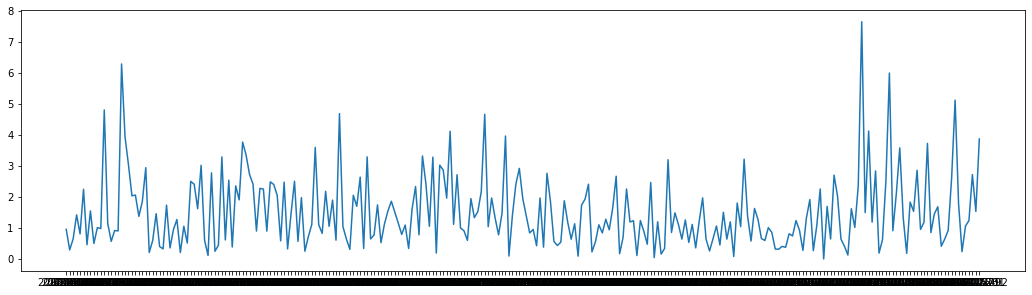

In [47]:
# help(plt.figure)
#plt.figure(figsize=(18,4.8))
#plt.plot(df_hr.date.values, df_hr.rate_pl.values)
# plt.figure(figsize=(18,4.8))
# plt.plot(df_hr.date.values, df_hr.rate_cl.values)

In [167]:
q_hr = select("SELECT date,open,high,low,close,preclose,pctChg FROM stock_k_data_d WHERE code='sh.600276' AND date>'2020-01-01' ORDER BY date")
df_hr = pd.DataFrame(q_hr, columns=["date","open","high","low","close","preclose","pctChg"])
# 开盘（对昨日收盘价）涨跌幅
df_hr['rate_o']=df_hr.apply(lambda r:0 if r['preclose']==0 else round((r['open'] - r['preclose']) * 100 / r['preclose'], 4), axis='columns')
# 当日振幅（盘中最高价对最低价涨幅）
df_hr['rate_hl']=df_hr.apply(lambda r:0 if r['low']==0 else round((r['high'] - r['low']) * 100 / r['low'], 4), axis='columns')
# 最低价对开盘价涨幅
df_hr['rate_lo']=df_hr.apply(lambda r:0 if r['open']==0 else round((r['low'] - r['open']) * 100 / r['open'], 4), axis='columns')
# 最高价对开盘价涨幅
df_hr['rate_ho']=df_hr.apply(lambda r:0 if r['open']==0 else round((r['high'] - r['open']) * 100 / r['open'], 4), axis='columns')
# 收盘价对最低价涨幅
df_hr['rate_cl']=df_hr.apply(lambda r:0 if r['low']==0 else round((r['close'] - r['low']) * 100 / r['low'], 4), axis='columns')
# 收盘价对最高价跌幅
df_hr['rate_ch']=df_hr.apply(lambda r:0 if r['high']==0 else round((r['close'] - r['high']) * 100 / r['high'], 4), axis='columns')
# 最低价对昨日收盘价涨幅
df_hr['rate_lp']=df_hr.apply(lambda r:0 if r['preclose']==0 else round((r['low'] - r['preclose']) * 100 / r['preclose'], 4), axis='columns')
# 最高价对昨日收盘价涨幅
df_hr['rate_hp']=df_hr.apply(lambda r:0 if r['preclose']==0 else round((r['high'] - r['preclose']) * 100 / r['preclose'], 4), axis='columns')

datePAry = [*df_hr.date.values]

line = Line()

line.add_xaxis(datePAry)
# 最低价相对前日收盘价涨跌幅
line.add_yaxis("最低价涨跌幅", [*df_hr.rate_lp.values], is_smooth=True,
#               markpoint_opts=opts.MarkPointOpts(
#                   data = [
#                       opts.MarkPointItem(type_="max", name="最大值"),
#                       opts.MarkPointItem(type_="min", name="最小值")
#                   ]),
               markline_opts=opts.MarkLineOpts(
                   data = [opts.MarkLineItem(type_="average", name="LP平均值")]),
               is_symbol_show=False
              )
# 最高价相对前日收盘价涨跌幅
line.add_yaxis("最高价涨跌幅", [*df_hr.rate_hp.values], is_smooth=True,
#               markpoint_opts=opts.MarkPointOpts(
#                   data = [
#                       opts.MarkPointItem(type_="max", name="最大值"),
#                       opts.MarkPointItem(type_="min", name="最小值")
#                   ]),
               markline_opts=opts.MarkLineOpts(
                   data = [opts.MarkLineItem(type_="average", name="LP平均值")]),
               is_symbol_show=False
              )
line.add_yaxis("当日收盘价相对最低价涨跌幅", [*df_hr.rate_cl.values], is_smooth=True,
#               markpoint_opts=opts.MarkPointOpts(
#                   data = [
#                       opts.MarkPointItem(type_="max", name="最大值"),
#                       opts.MarkPointItem(type_="min", name="最小值")
#                   ]),
               markline_opts=opts.MarkLineOpts(
                   data = [opts.MarkLineItem(type_="average", name="CL平均值")]),
               is_symbol_show=False
              )
line.add_yaxis("当日收盘涨跌幅", [*df_hr.pctChg.values], is_smooth=True,
#               markpoint_opts=opts.MarkPointOpts(
#                   data = [
#                       opts.MarkPointItem(type_="max", name="最大值"),
#                       opts.MarkPointItem(type_="min", name="最小值")
#                   ]),
               markline_opts=opts.MarkLineOpts(
                   data = [opts.MarkLineItem(type_="average", name="CL平均值")]),
               is_symbol_show=False
              )
line.set_global_opts(
    title_opts=opts.TitleOpts(title='每日涨跌幅分析'),
    tooltip_opts=opts.TooltipOpts(trigger="axis")
)
line.render_notebook()

### 关于BaoStock
1. BaoStock的登录接口调用似乎限制了接口获取数据的最后日期，只能获取登录日期之前的数据。juypter notebook使用昨日的登录结果，调用接口时得不到今天的数据。
2. 日K线数据入库：交易日17:30；分钟K线数据入库：交易日20:30；“其它财务报告数据”入库：次日1:30

### 2021-02-07
- 分析了大盘近一年的成交量
- 分析了恒瑞医药近一年的盘中最大跌幅、盘中最大涨幅、收盘涨幅、收盘相对盘中最低价涨幅；平均最低价跌幅-1.32%；平均最高价涨幅1.55%；是否可以定义个跌幅大于-1.32%时买入，涨幅大于1.55%时卖出的短线操作策略。
- matplotlib绘图不知道如何能够鼠标悬浮显示数值，改成了pyecharts绘图。


### 2021-02-02
- 代码健壮性优化

### 2021-01-29
- 增加收盘文字播报
- 沪深300、中证500成分股落库`stock_hs300_zz500`

### 2021-01-28 
- 2000-01-01至2021-01-27市场指数落库`market_index`
- 补充换手率